# PROOF OF CONCEPT

In [1]:
import os
import numpy as np
import cv2
import shutil
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet_v2, inception_v3, inception_resnet_v2, efficientnet_v2
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models

In [2]:
## GLOBAL VARIRABLES
input_shape = (224,224)
channels = 3
epochs = 256
batch_size = 8
preprocessing_function=inception_v3.preprocess_input

## Path Declerations
dataPath = "pngData"
noBgDataPath="noBgData"
classes = os.listdir(dataPath)
path = "data"
trainPath = os.path.join(path,"train")
valPath = os.path.join(path,"val")

## PREPROCESSING

In [3]:
# ## Showing Sample Images WITH BG
rawImagePath = "pngData\9\9P--2-_png.rf.86bd5fc1ea384155983df7316c11eea3.png"
rawImage = cv2.imread(rawImagePath)
# for i in rawImage: 
#     print(i)


In [4]:
# ## Showing Sample Images NO BG
processedImagePath = "noBgData\9\9P--2-_png.rf.86bd5fc1ea384155983df7316c11eea3.png"
processedImage = cv2.imread(processedImagePath)
# for i in processedImage: 
#     print(i)


In [5]:
processedImage.shape

(224, 224, 3)

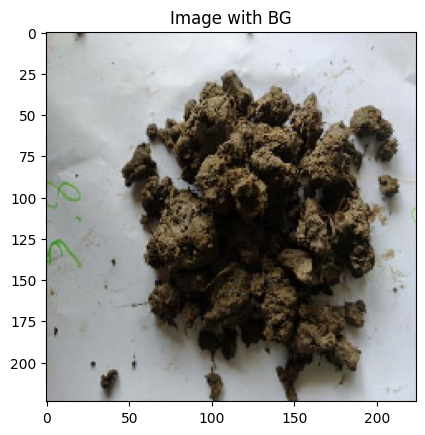

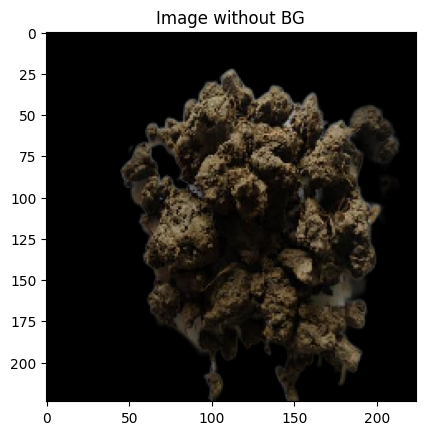

In [6]:
## Showing Sample Images

colorRawImage = cv2.cvtColor(rawImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorRawImage)
plt.title('Image with BG')
plt.show()

colorProcessedImage = cv2.cvtColor(processedImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorProcessedImage)
plt.title('Image without BG')
plt.show()

In [7]:
print("Train Images per Class", len(os.listdir('data//train//7')))
print("Validation Images per Class", len(os.listdir('data//val//7')))

Train Images per Class 303
Validation Images per Class 76


In [8]:
trainGenerator = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    rotation_range=45,
                                    preprocessing_function=preprocessing_function,
                                    ).flow_from_directory(
                                            directory=trainPath,
                                            target_size=input_shape,
                                            class_mode='categorical',
                                            batch_size=batch_size
                                        )

valGenerator = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocessing_function,
                                  ).flow_from_directory(
                                        directory=valPath,
                                        target_size=input_shape,
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

Found 839 images belonging to 4 classes.
Found 210 images belonging to 4 classes.


 ## MODEL TRAINING

In [9]:
tf_model = inception_v3.InceptionV3(include_top=False,
                            weights="imagenet",
                            input_shape= input_shape+(channels,)
                            )

In [10]:

model = Sequential()
model.add(tf_model)
model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))

# model.add(layers.BatchNormalization())

# model.add(layers.Dense(units=2048, kernel_regularizer=L2()))
# model.add(layers.LeakyReLU())
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=512, kernel_regularizer=L2()))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=2048, kernel_regularizer=L2()))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=4096, kernel_regularizer=L2()))
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              1050624   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2048)              0

In [11]:
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(1e-4),
                metrics=['acc']
                )

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-7)
es = EarlyStopping(monitor='loss', patience=6)

history = model.fit(trainGenerator, validation_data = valGenerator, 
                        epochs = epochs, callbacks=[reduce_lr, es], 
                        verbose = 1)

Epoch 1/256
105/105 [==============================] - 28s 170ms/step - loss: 45.8053 - acc: 0.3004 - val_loss: 43.6974 - val_acc: 0.3667 - lr: 1.0000e-04
Epoch 2/256
105/105 [==============================] - 14s 131ms/step - loss: 41.8734 - acc: 0.3552 - val_loss: 39.9904 - val_acc: 0.2714 - lr: 1.0000e-04
Epoch 3/256
105/105 [==============================] - 14s 131ms/step - loss: 38.1881 - acc: 0.3754 - val_loss: 36.3926 - val_acc: 0.3571 - lr: 1.0000e-04
Epoch 4/256
105/105 [==============================] - 14s 131ms/step - loss: 34.5246 - acc: 0.4577 - val_loss: 33.0582 - val_acc: 0.2476 - lr: 1.0000e-04
Epoch 5/256
105/105 [==============================] - 14s 131ms/step - loss: 31.1236 - acc: 0.5256 - val_loss: 29.7181 - val_acc: 0.4571 - lr: 1.0000e-04
Epoch 6/256
105/105 [==============================] - 14s 131ms/step - loss: 27.8839 - acc: 0.5876 - val_loss: 26.8730 - val_acc: 0.2571 - lr: 1.0000e-04
Epoch 7/256
105/105 [==============================] - 14s 130ms/step 

### TRAINING RESULTS


In [13]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

best_epoch = np.argmax(np.array(val_acc))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train Accuracy: {:.4f}".format(train_acc[best_epoch]))
print("Final Test Accuracy: {:.4f}".format(val_acc[best_epoch]))

Best Epoch:  29
Final Train Loss: 1.3820
Final Validation Loss: 2.4095
Final Train Accuracy: 0.8784
Final Test Accuracy: 0.6286


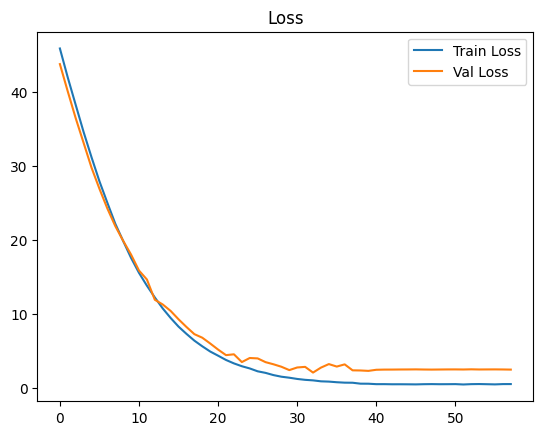

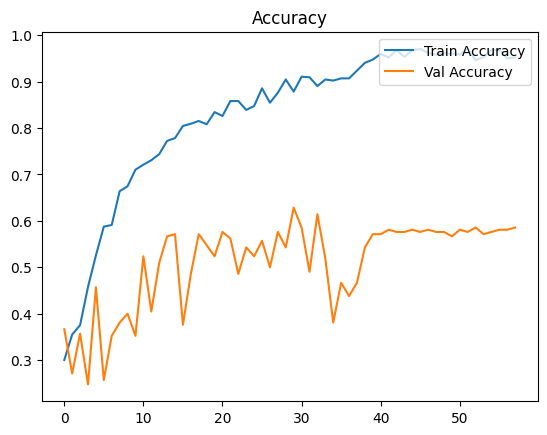

In [14]:

plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Loss")
plt.legend(["Train Loss", "Val Loss"], loc="upper right")
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Accuracy")
plt.legend(["Train Accuracy", "Val Accuracy"], loc="upper right")
plt.show()


In [15]:
# Pre-processing the image
img_path= "noBgData//6//43--10-_png.rf.515324d7c28acb83c837f6b6ebcf68f7.png"

img = image.load_img(img_path, target_size = input_shape)
img_tensor = image.img_to_array(img)
img_tensor = preprocessing_function(img_tensor)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor = img_tensor / 255.
  
# Print image tensor shape
print(img_tensor.shape)

(1, 224, 224, 3)


In [16]:
layers = [layer for layer in model.layers[0].layers]
conv_layers = [layer for layer in layers if "conv" in layer.name]
sample_layers = [layer for n,layer in enumerate(conv_layers) if n%50 == 0]

print(layers[:5])

[<keras.engine.input_layer.InputLayer object at 0x000001E59BAC1EE0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E59BAB0070>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001E59BA89B20>, <keras.layers.core.activation.Activation object at 0x000001E59975C9A0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001E59DC3FF40>]


In [17]:
def plot_map(layer_activation=0, row=4, col=8):
    # plot all maps
    ix = 1
    for _ in range(col):
        for _ in range(row):
            # specify subplot and turn of axis
            ax = plt.subplot(row, col, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(layer_activation[0, :, :, ix-1], cmap='viridis')
            ix += 1
    # show the figure
    plt.show()

1/1 [==============================] - 2s 2s/step


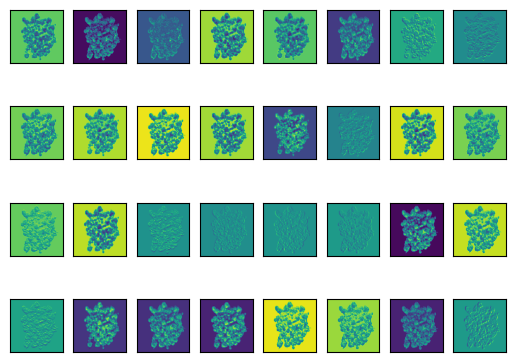

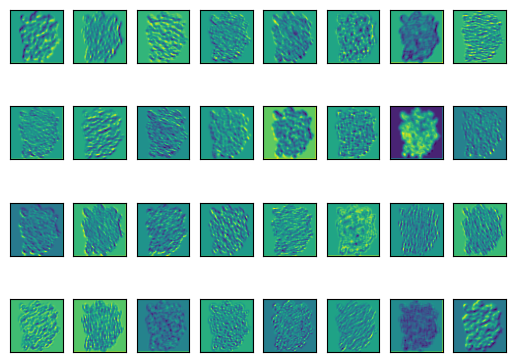

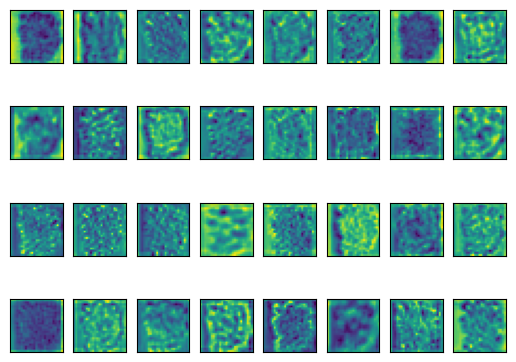

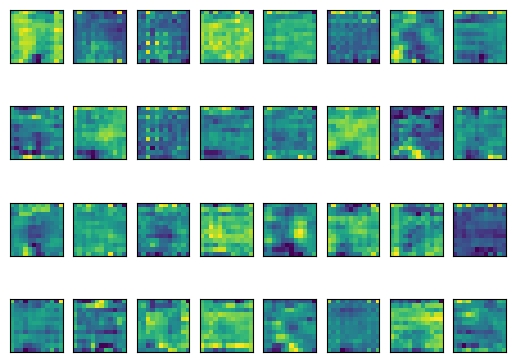

In [18]:
# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in conv_layers]
activation_model = models.Model(inputs = model.layers[0].input, outputs = layer_outputs)
feature_maps = activation_model.predict(img_tensor)

## Showing Feature maps
plot_map(feature_maps[0])
plot_map(feature_maps[4])
plot_map(feature_maps[16])
plot_map(feature_maps[64])
# plot_map(feature_maps[200])



## MODEL TESTING

## SAVING